[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/CV/blob/main/data_augmentation/gan/latent_gan_ffnn.ipynb)


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import torchvision
from torchvision.utils import make_grid

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Dataset

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # Define the transformation to normalize the data between 1 and -1 (mean = 0.5 and variance = 0.5 will transform to values between 1 and -1)
mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True) # downloading the MNIST train dataset and then applying some transformations
mnist_loader = DataLoader(dataset=mnist, batch_size=128, shuffle=True) # loading the downloaded dataset

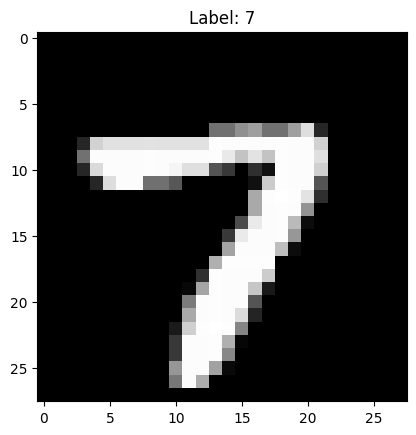

In [ ]:
# Display one image from one of the batches
images, labels = next(iter(mnist_loader)) # Extract one batch of images and labels
image = images[0].numpy().squeeze() # loading the one image from that batch
label = labels[0].item() # loading the actual label of the above image

import matplotlib.pyplot as plt
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

## Modelling

In [ ]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()

        '''
        # input layer units = img_h*img_w*channel = 28*28*1 = 784
        # encoder hidden layer 1 units = 128
        # latent layer units = 10
        # decoder hidden layer 1 units = 128
        # output layer units = 28*28*1 = 784
        '''
        self.input_layer = nn.Sequential(nn.Linear(28*28*1, 128),nn.BatchNorm1d(128),nn.LeakyReLU())
        self.hidden_layer_1 = nn.Sequential(nn.Linear(128, 10),nn.BatchNorm1d(10),nn.LeakyReLU())
        self.hidden_layer_2 = nn.Sequential(nn.Linear(10, 128),nn.BatchNorm1d(128),nn.LeakyReLU())
        self.output_layer = nn.Sequential(nn.Linear(128, 28*28*1),nn.Identity(),nn.Tanh()) #tanh because we transformed the org img between 1 and -1 and hence predicted image should also be between 1 and -1 and hence tanh

    def forward(self, z):
        batch_size = z.shape[0]

        # flattening the image
        out = torch.flatten(z, start_dim=1) # or use this z.reshape(-1, 28*28*1)

        # passing it through all the layers
        out = self.input_layer(out)
        latent_out = self.hidden_layer_1(out)
        out = self.hidden_layer_2(latent_out)
        out = self.output_layer(out)

        return latent_out.reshape(batch_size, 1, -1, 10), out

In [ ]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()
        self.input_layer = nn.Sequential(nn.Linear(10, 128),nn.LayerNorm(128),nn.LeakyReLU())
        self.output_layer = nn.Sequential(nn.Linear(128, 1),nn.Identity(),nn.Sigmoid()) # Identity is used when you dont want any normalization
        # instead of layer norm here also you can use batch norm but layer norm gives better results

    def forward(self, x):
        # Flattening the image input
        out = x.reshape(-1, 10)
        out = self.input_layer(out)
        out = self.output_layer(out)
        return out

## Training

In [ ]:
from torch.optim import Adam

# Instantiate generator model
generator = Generator().to(device)
generator.train()
optimizer_generator = Adam(generator.parameters(), lr=1E-4, betas=(0.5, 0.999)) #0.5 is momentum

# Instantiate discriminator model
discriminator = Discriminator().to(device)
discriminator.train()
optimizer_discriminator = Adam(discriminator.parameters(), lr=1E-4, betas=(0.5, 0.999)) #0.5 is momentum

In [ ]:
from torchinfo import summary
summary(generator, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

In [ ]:
for epoch in range(20): # for each epoch
    generator_losses = []
    discriminator_losses = []
    mean_real_dis_preds = []
    mean_fake_dis_preds = []

    for im, _ in tqdm(mnist_loader): # for each image in each epoch

        real_ims = im.float().to(device)
        batch_size = real_ims.shape[0]

        ''' ######################### First Optimizing the Discriminator ######################### '''

        optimizer_discriminator.zero_grad()

        real_latent_im , _ = generator(real_ims)
        fake_latent_im_noise = torch.randn((batch_size, 10), device=device) # creating a noisy data
        disc_real_pred = discriminator(real_latent_im) # passing real image to the discriminator
        disc_fake_pred = discriminator(fake_latent_im_noise.detach()) # passing fake image to the discriminator but we are detaching it so that gradients are not computed for generator and generator is not trained while training the discriminator

        disc_loss = -torch.mean(torch.log(disc_real_pred.reshape(-1) + 0.0001) + torch.log(1. - disc_fake_pred.reshape(-1) + 0.0001) )

        disc_loss.backward()
        optimizer_discriminator.step()

        mean_real_dis_preds.append(torch.nn.Sigmoid()(disc_real_pred).mean().item())
        mean_fake_dis_preds.append(torch.nn.Sigmoid()(disc_fake_pred).mean().item())


        ''' ######################### Second Optimizing the Generator ######################### '''
        optimizer_generator.zero_grad()

        real_latent_im , _ = generator(real_ims) # passing through generator to create fake image
        disc_real_pred = discriminator(real_latent_im) # passing through discriminator to classify it as fake or real

        gen_fake_loss = -torch.mean(torch.log(disc_real_pred.reshape(-1) + 0.0001))

        gen_fake_loss.backward()
        optimizer_generator.step()

        generator_losses.append(gen_fake_loss.item())
        discriminator_losses.append(disc_loss.item())

    print(f'''Finished epoch:{epoch + 1} | Generator Loss : {np.mean(generator_losses)} | Discriminator Loss : {np.mean(discriminator_losses)} | Discriminator real pred : {np.mean(mean_real_dis_preds)} | Discriminator fake pred : {np.mean(mean_fake_dis_preds)}''')

100%|██████████| 469/469 [00:16<00:00, 27.74it/s]


Finished epoch:1 | Generator Loss : 0.23719152549245973 | Discriminator Loss : 0.6519804416434851 | Discriminator real pred : 0.6882056028349821 | Discriminator fake pred : 0.576531462323691


100%|██████████| 469/469 [00:15<00:00, 30.65it/s]


Finished epoch:2 | Generator Loss : 0.06399330745405479 | Discriminator Loss : 0.1971760365500379 | Discriminator real pred : 0.718691819766437 | Discriminator fake pred : 0.5267490261653339


100%|██████████| 469/469 [00:15<00:00, 30.73it/s]


Finished epoch:3 | Generator Loss : 0.02311195559632867 | Discriminator Loss : 0.0690126364101479 | Discriminator real pred : 0.7265199847312879 | Discriminator fake pred : 0.5098955236009951


100%|██████████| 469/469 [00:15<00:00, 29.62it/s]


Finished epoch:4 | Generator Loss : 0.010031225288838846 | Discriminator Loss : 0.029041779231526323 | Discriminator real pred : 0.7290695459603755 | Discriminator fake pred : 0.5042926800022247


100%|██████████| 469/469 [00:15<00:00, 30.91it/s]


Finished epoch:5 | Generator Loss : 0.0048273787625245194 | Discriminator Loss : 0.01407169498729585 | Discriminator real pred : 0.7300896258242349 | Discriminator fake pred : 0.5021682052469966


100%|██████████| 469/469 [00:15<00:00, 30.74it/s]


Finished epoch:6 | Generator Loss : 0.0025646103074901234 | Discriminator Loss : 0.007702125961691745 | Discriminator real pred : 0.730534295283401 | Discriminator fake pred : 0.5012455006906473


100%|██████████| 469/469 [00:15<00:00, 30.36it/s]


Finished epoch:7 | Generator Loss : 0.0015085541016694262 | Discriminator Loss : 0.004602150174417793 | Discriminator real pred : 0.7307418879669613 | Discriminator fake pred : 0.5007716665135772


100%|██████████| 469/469 [00:15<00:00, 29.94it/s]


Finished epoch:8 | Generator Loss : 0.0009295566032068737 | Discriminator Loss : 0.002991486497884636 | Discriminator real pred : 0.7308557610521947 | Discriminator fake pred : 0.5005206117497832


100%|██████████| 469/469 [00:15<00:00, 30.95it/s]


Finished epoch:9 | Generator Loss : 0.0005809754625445346 | Discriminator Loss : 0.0019190966376045873 | Discriminator real pred : 0.7309243756570796 | Discriminator fake pred : 0.5003494711827113


100%|██████████| 469/469 [00:15<00:00, 30.62it/s]


Finished epoch:10 | Generator Loss : 0.00037704463894250615 | Discriminator Loss : 0.001330943554014301 | Discriminator real pred : 0.7309644972083411 | Discriminator fake pred : 0.5002542856151361


100%|██████████| 469/469 [00:16<00:00, 29.07it/s]


Finished epoch:11 | Generator Loss : 0.0002554577576661252 | Discriminator Loss : 0.0009180841417531413 | Discriminator real pred : 0.7309881752487947 | Discriminator fake pred : 0.5001879669964187


100%|██████████| 469/469 [00:15<00:00, 30.58it/s]


Finished epoch:12 | Generator Loss : 0.00015544733534299476 | Discriminator Loss : 0.0006328418811555825 | Discriminator real pred : 0.7310080244851265 | Discriminator fake pred : 0.5001406682325579


100%|██████████| 469/469 [00:15<00:00, 30.49it/s]


Finished epoch:13 | Generator Loss : 9.95105189132392e-05 | Discriminator Loss : 0.0004395523943741228 | Discriminator real pred : 0.7310184078938418 | Discriminator fake pred : 0.5001074670474412


100%|██████████| 469/469 [00:17<00:00, 26.87it/s]


Finished epoch:14 | Generator Loss : 4.38685099624384e-05 | Discriminator Loss : 0.0002717017950243138 | Discriminator real pred : 0.7310300296557738 | Discriminator fake pred : 0.5000808945596854


100%|██████████| 469/469 [00:15<00:00, 30.02it/s]


Finished epoch:15 | Generator Loss : 1.622378325527064e-05 | Discriminator Loss : 0.00021006563472329948 | Discriminator real pred : 0.7310339091683248 | Discriminator fake pred : 0.5000684870077349


100%|██████████| 469/469 [00:15<00:00, 30.44it/s]


Finished epoch:16 | Generator Loss : -1.231586985759854e-05 | Discriminator Loss : 0.0001047653373924303 | Discriminator real pred : 0.7310396364248638 | Discriminator fake pred : 0.5000517347982443


100%|██████████| 469/469 [00:19<00:00, 24.56it/s]


Finished epoch:17 | Generator Loss : -2.6301991945861108e-05 | Discriminator Loss : 4.55034556179909e-05 | Discriminator real pred : 0.7310437472390213 | Discriminator fake pred : 0.5000420974007548


100%|██████████| 469/469 [00:15<00:00, 30.83it/s]


Finished epoch:18 | Generator Loss : -4.881916641455069e-05 | Discriminator Loss : -2.582995186267949e-05 | Discriminator real pred : 0.7310484140666563 | Discriminator fake pred : 0.5000305513837444


100%|██████████| 469/469 [00:15<00:00, 31.00it/s]


Finished epoch:19 | Generator Loss : -5.925298925689594e-05 | Discriminator Loss : -5.953276144018693e-05 | Discriminator real pred : 0.7310503583981284 | Discriminator fake pred : 0.5000245555885819


100%|██████████| 469/469 [00:15<00:00, 30.87it/s]

Finished epoch:20 | Generator Loss : -5.551706073853131e-05 | Discriminator Loss : -5.484360149442983e-05 | Discriminator real pred : 0.7310490631091315 | Discriminator fake pred : 0.5000237944537896


# Inference

In [ ]:
# Getting 100 random indexes
idxs = torch.randint(0, len(mnist)-1, (100, ))

# using these indexes to get images from mnist dataset and concatenating them
test_ims = torch.cat([mnist[idx][0][None, :] for idx in idxs]).float()
test_ims = test_ims.float().to(device)

# generating images for the above test dataset
_, generated_im = generator(test_ims)

In [ ]:
generated_im = torch.clamp(generated_im, -1., 1.).detach().cpu() # clamping the generated images
generated_im = 0.5*generated_im + 0.5 #detransforming the images from [-1,1] to [0,1]

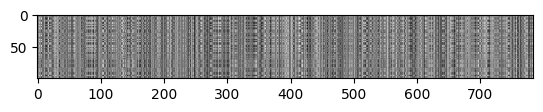

In [ ]:
# now printing the predicted images
grid = torchvision.utils.make_grid(generated_im, nrow=10)
img = torchvision.transforms.ToPILImage()(grid)
plt.imshow(img, cmap='gray') # now display the image here using matplot lib